# Decision tree, KNN, Logit regression and SVM Models on Breast Cancer Data

Specifically, build decision tree, k-NN techniques, logistic regression and SVM (explore how well model performs for several different hyper-parameter values). Present a brief overview of your predictive modeling process, explorations, and discuss your results. Make sure you present information about the model “goodness” (possible things to think about: confusion matrix, predictive accuracy, precision, recall, f-measure). Briefly discuss ROC and lift curves.


Present a brief overview of your predictive modeling process, explorations, and discuss your results. Make sure you present information about the model “goodness” (possible things to think about: confusion matrix, predictive accuracy, classification error, precision, recall, f-measure).


## Setup and Explore the Data

In [1]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [2]:
raw  = pd.read_csv('data.csv')

After a quick look at the data, it is easy to identify that 'Diagnosis' label is our class label.

In [3]:
# id can't not be classified
X = raw.drop(columns=['id','diagnosis'])
# now as ou know our diagnosis column is a object type so we can map it to integer value
y=raw['diagnosis'].map({'M':1,'B':0})

In [4]:
features_mean= list(X.columns[0:10])
features_se= list(X.columns[10:20])
features_worst=list(X.columns[20:31])

In my opinion area_worst in last swarm plot looks like malignant and benign are seprated not totaly but mostly. Hovewer, smoothness_se in swarm plot 2 looks like malignant and benign are mixed so it is hard to classfy while using this feature.

### Feature Correlations

Feature Correlation:



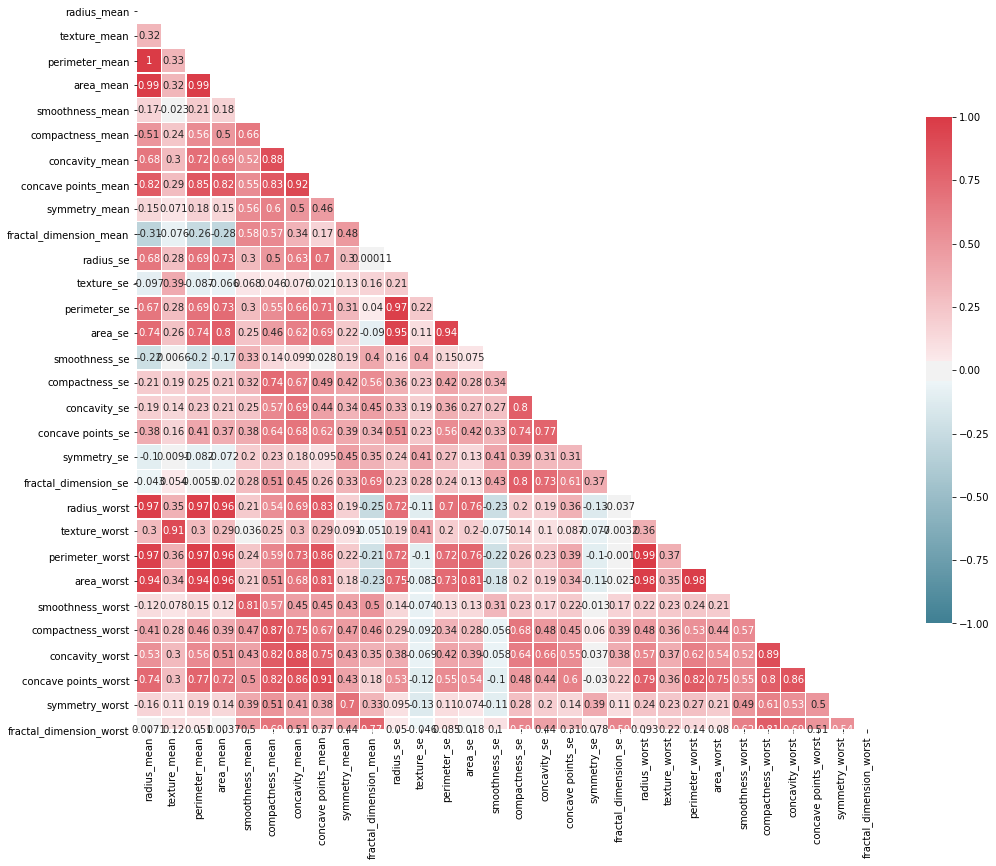

In [5]:
print("Feature Correlation:\n")

#f,ax = plt.subplots(figsize=(15, 15))
#sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);


# Set figure size
f, ax = plt.subplots(figsize=(15, 15))

# Mask for the upper triangle
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(X.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

As it can be seen in map heat figure:
- radius_mean, perimeter_mean and area_mean, radius_worst, perimeter_worst, area_worst, radius_se, perimeter_se and area_se are correlated with each other so we will use only **area_mean**.
- Compactness_mean, concavity_mean and concave points_mean, Compactness_worst, concavity_worst and concave points_worst, Compactness_se, concavity_se and concave points_se, are correlated with each other. I only choose **concavity_mean**. 
- symmetry_mean, symmetry_worst are correlated, choose **symmetry_mean**.
- fractal_dimension_mean, fractal_dimension_worst are correlated, choose *fractal_dimension_mean*.
- texture_mean and texture_worst are correlated and I use texture_mean. 
- smoothness_mean, smoothness_se and smoothness_worst are correlated. I use smoothness_worst.

### Initial Feature Selection

retain only features that are not correlated_ X_retained

In [6]:
X_retained = X.drop(columns=['radius_mean','perimeter_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 
                             'radius_se','perimeter_se','area_se','smoothness_mean','smoothness_se','compactness_mean', 
                             'concave points_mean', 'compactness_worst', 
                             'concave points_worst', 'concavity_worst', 
                             'symmetry_worst','compactness_se','concave points_se','concavity_se','fractal_dimension_worst','texture_worst'])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_retained, y, test_size=0.3, random_state = 41)
print('\n Feature Names:', X.columns.values, "\n")


 Feature Names: ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean'
 'radius_se' 'texture_se' 'perimeter_se' 'area_se' 'smoothness_se'
 'compactness_se' 'concavity_se' 'concave points_se' 'symmetry_se'
 'fractal_dimension_se' 'radius_worst' 'texture_worst' 'perimeter_worst'
 'area_worst' 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst'] 



Let's take a look at the correlation matrix once again, this time created with our trimmed-down set of variables.

Feature Correlation:



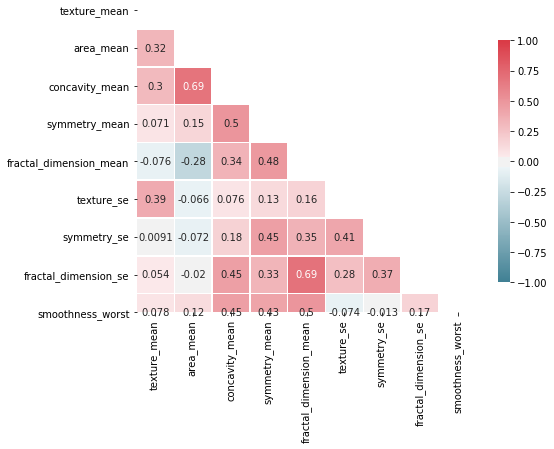

In [7]:
# Draw the heatmap again, with the new correlation matrix
print("Feature Correlation:\n")
f, ax = plt.subplots(figsize=(8, 8))

mask = np.zeros_like(X_retained.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(X_retained.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

### Data Scaled and Split

In [8]:
# normalizing data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X_retained)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=13, stratify=y)

## Decision tree

### HyperTuning

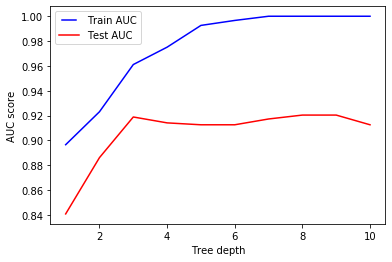

In [9]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc

#----------------- AUC plot with different max depth hyper setting
max_depths = np.linspace(1, 10, 10, endpoint=True)

train_results = []
test_results = []
training_accuracy = []
test_accuracy = []

for max_depth in max_depths:
    dtree = tree.DecisionTreeClassifier(max_depth=max_depth)
    dtree.fit(X_train, y_train)
    train_pred = dtree.predict(X_train)
    
    # Add auc score to previous train results
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)   
    
    # Add auc score to previous test results
    train_results.append(roc_auc)
    y_pred = dtree.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    test_results.append(roc_auc)
    
    training_accuracy.append(dtree.score(X_train, y_train))
    test_accuracy.append(dtree.score(X_test, y_test))
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, color = 'blue', label='Train AUC')
line2, = plt.plot(max_depths, test_results, color = 'red',label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

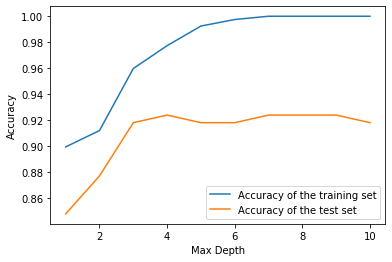

In [10]:
#----------------- Decision Tree Accuracy plot with different max depth hyper setting
plt.plot(max_depths,training_accuracy, label='Accuracy of the training set')
plt.plot(max_depths,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()

By having larger max_depth(>=3), we overfit the model into training data, so the accuracy for training set become 
but the accuracy for test set decrease.

From AUC and Accuracy plot, we could conclude that a potential reasonable max-depth is 3.

However,other parameters than can work with:
- min_samples_leaf, max_sample_leaf
- max_leaf_node

by looking at plot, best result accurs when max_depth is 3

### Model Performance

In [11]:
clf_tree = tree.DecisionTreeClassifier(max_depth=3)
clf_tree = clf_tree.fit(X_train, y_train)

y_predict_tree = clf_tree.predict(X_test)
print('Accuracy of Decision Tree classifier on reduced test set: {:.4f}'.format(accuracy_score(y_test, y_predict_tree)))

Accuracy of Decision Tree classifier on reduced test set: 0.9181


In [13]:
from sklearn.model_selection import cross_val_score

dtree_scores = cross_val_score(clf_tree, X_scaled, y, cv=10)
print(dtree_scores)
print('cv_scores mean:{0:.4f}'.format(dtree_scores.mean()))

[0.93103448 0.86206897 0.92982456 0.92982456 0.92982456 0.92982456
 0.94736842 0.94642857 0.96428571 0.98214286]
cv_scores mean:0.9353


In [14]:
#----------------- Decision Tree Confusion Matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict_tree),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign']
)

,Predicted Malignant,Predicted Benign
True Malignant,98,9
True Benign,5,59


Let's look at the decision tree diagram 

/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


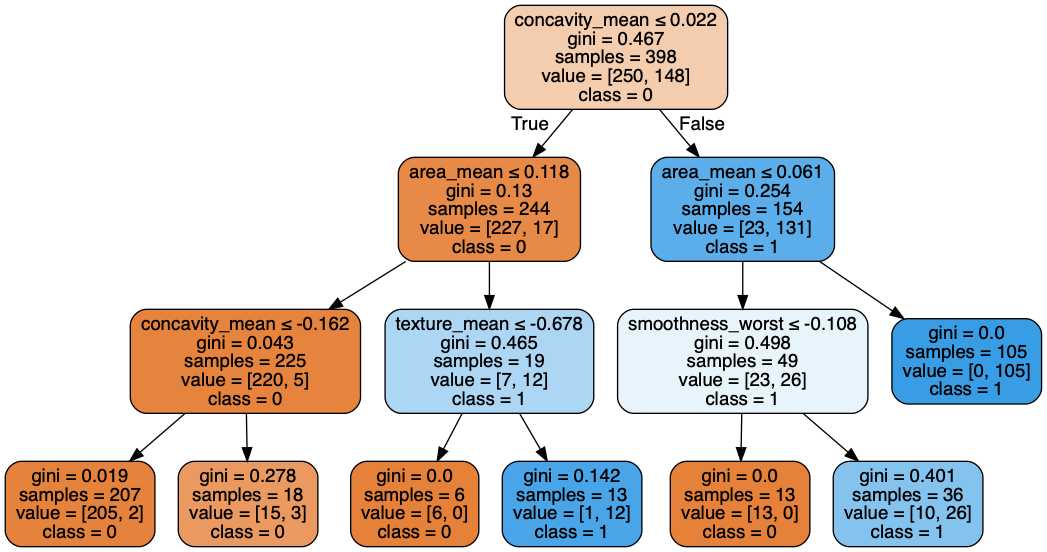

In [15]:
#----------------- Decision Tree Diagram with the max depth of 5
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_retained.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Breast cancer attributes.png')
Image(graph.create_png())

## K-NN

### Hypertuning using GridSearchCV

In [16]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn = neighbors.KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
#fit model to data
knn_gscv.fit(X_scaled, y)

print(knn_gscv.best_params_)
print('Best score achieved:',knn_gscv.best_score_)

{'n_neighbors': 5}
Best score achieved: 0.9490333919156415


/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Model Performance

In [17]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)

print('holdout score:{0:.4f}'.format(knn.score(X_test,y_test)))

knn_scores = cross_val_score(knn, X_scaled, y, cv=10)

print(knn_scores)
print('Cross validation scores mean:{0:.4f}'.format(np.mean(knn_scores)))

holdout score:0.9298
[0.98275862 0.93103448 0.96491228 0.94736842 0.98245614 0.92982456
 0.94736842 1.         0.91071429 0.89285714]
Cross validation scores mean:0.9489


In [18]:
#----------------- KNN Confusion Matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict_knn),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign']
)

,Predicted Malignant,Predicted Benign
True Malignant,104,3
True Benign,9,55


## Logistic Regression

### Fine tuning model

In [19]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1,1,1.5,2,2.2,3,10,100]
C= np.linspace(.1,5,5)
#C = np.logspace(-5, 8, 15) 
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='liblinear')
lr_gscv = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_lr = lr_gscv.fit(X_scaled, y)

print('Best Penalty:', best_lr.best_estimator_.get_params()['penalty'])
print('Best C:', best_lr.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.3250000000000002


### Model Performance

In [20]:
from sklearn.linear_model import LogisticRegression

clf_lr=LogisticRegression(C=1.325,penalty='l1')
clf_lr = clf_lr.fit(X_train,y_train)

y_predict_lr = clf_lr.predict(X_test)
lr_scores = cross_val_score(clf_lr, X_scaled, y, cv=10)


print("test accuracy: {} ".format(clf_lr.score(X_test, y_test)))
print("train accuracy: {} ".format(clf_lr.score(X_train, y_train)))

test accuracy: 0.9532163742690059 
train accuracy: 0.9773869346733668 


/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

In [21]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_lr),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign']
)

,Predicted Malignant,Predicted Benign
True Malignant,105,2
True Benign,6,58


## SVM

### Grid Search CV

In [109]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = [{'kernel': ['rbf'], 
               'gamma': 10. ** np.arange(-5, 4),
               'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['linear'], 
               'C': [0.1,  1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    svc_gscv = GridSearchCV(SVC(), parameters, cv=5, scoring=score)
    
    svc_gscv.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")

    print(svc_gscv.best_params_)
    print("\nGrid scores on development set:\n")

    means = svc_gscv.cv_results_['mean_test_score']
    stds = svc_gscv.cv_results_['std_test_score']
    
    print("\nDetailed classification report:")
    print("\nThe model is trained on the full development set.")
    print("\nThe scores are computed on the full evaluation set.\n")

    y_true, y_pred = y_test, svc_gscv.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       107
           1       1.00      0.53      0.69        64

    accuracy                           0.82       171
   macro avg       0.89      0.77      0.79       171
weighted avg       0.86      0.82      0.81       171


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       107

/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Fit the model 

In [23]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC(kernel = 'rbf', random_state = 0, C=1000, gamma= 0.001)
svm.fit(X_train, y_train)

y_predict_svm = svm.predict(X_test)
svm_scores = cross_val_score(svm, X_scaled, y, cv=10)


print('acc on train dataset: {:.3f}'.format(svm.score(X_train,y_train)))
print('acc on test dataset: {:.3f}'.format(svm.score(X_test,y_test)))
print("Cross-Validation Score :{0:.3f}".format(svm_scores.mean()))

acc on train dataset: 0.977
acc on test dataset: 0.953
Cross-Validation Score :0.961


In [24]:
#----------------- Decision Tree Confusion Matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict_svm),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign']
)

,Predicted Malignant,Predicted Benign
True Malignant,105,2
True Benign,6,58


##  Model Evaluation and Conclusion

### ROC Curve

/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


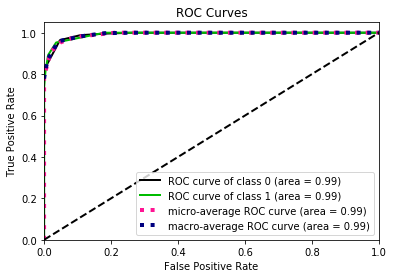

In [25]:
y_probas = knn.predict_proba(X_train)

skplt.metrics.plot_roc_curve(y_train, y_probas, cmap='nipy_spectral')
plt.show()


**SVM vs Logistic Regression**

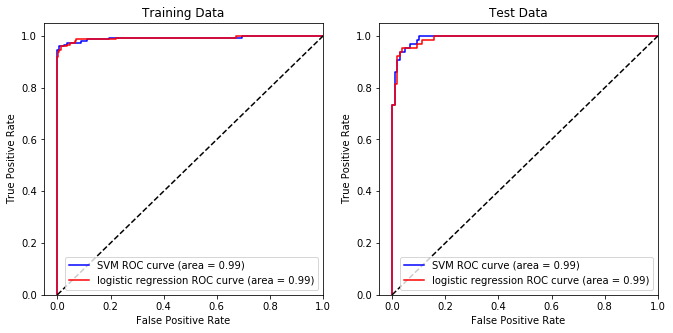

In [26]:
y_train_score1 = svm.decision_function(X_train)
y_train_score2 = clf_lr.decision_function(X_train)

false_pos_rate1, true_pos_rate1, _ = roc_curve(y_train, y_train_score1)
roc_auc1 = auc(false_pos_rate1, true_pos_rate1)

false_pos_rate2, true_pos_rate2, _ = roc_curve(y_train, y_train_score2)
roc_auc2 = auc(false_pos_rate2, true_pos_rate2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.plot(false_pos_rate1, true_pos_rate1, label='SVM ROC curve (area = %0.2f)' % roc_auc1, color='b')
ax1.plot(false_pos_rate2, true_pos_rate2, label='logistic regression ROC curve (area = %0.2f)' % roc_auc2, color='r')
ax1.set_title('Training Data')


y_test_score1 = svm.decision_function(X_test)
y_test_score2 = clf_lr.decision_function(X_test)

false_pos_rate1, true_pos_rate1, _ = roc_curve(y_test, y_test_score1)
roc_auc1 = auc(false_pos_rate1, true_pos_rate1)

false_pos_rate2, true_pos_rate2, _ = roc_curve(y_test, y_test_score2)
roc_auc2 = auc(false_pos_rate2, true_pos_rate1)

ax2.plot(false_pos_rate1, true_pos_rate1, label='SVM ROC curve (area = %0.2f)' % roc_auc1, color='b')
ax2.plot(false_pos_rate2, true_pos_rate2, label='logistic regression ROC curve (area = %0.2f)' % roc_auc2, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

**KNN vs Decision Tree**

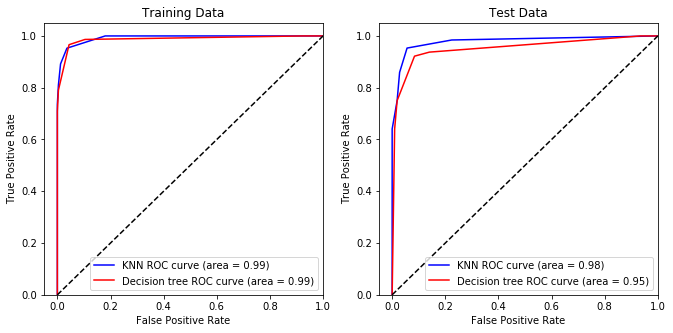

In [27]:
"""
For KNN and Decision Tree, we need to use predict_proba instead of decision function to calculate roc curve; 
Also, prob is y_train_prob1[:,1]
"""
# training data
y_train_prob1 = knn.predict_proba(X_train)
y_train_prob2 = clf_tree.predict_proba(X_train)

fpr1, tpr1, _ = roc_curve(y_train, y_train_prob1[:,1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_train, y_train_prob2[:,1])
roc_auc2 = auc(fpr2, tpr2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.plot(fpr1, tpr1, label='KNN ROC curve (area = %0.2f)' % roc_auc1, color='b')
ax1.plot(fpr2, tpr2, label='Decision tree ROC curve (area = %0.2f)' % roc_auc2, color='r')
ax1.set_title('Training Data')


# Test data
y_test_prob1 = knn.predict_proba(X_test)
y_test_prob2 = clf_tree.predict_proba(X_test)

fpr1, tpr1, _ = roc_curve(y_test, y_test_prob1[:,1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_prob2[:,1])
roc_auc2 = auc(fpr2, tpr2)

ax2.plot(fpr1, tpr1, label='KNN ROC curve (area = %0.2f)' % roc_auc1, color='b')
ax2.plot(fpr2, tpr2, label='Decision tree ROC curve (area = %0.2f)' % roc_auc2, color='r')
ax2.set_title('Test Data')


for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

### Lift Curve

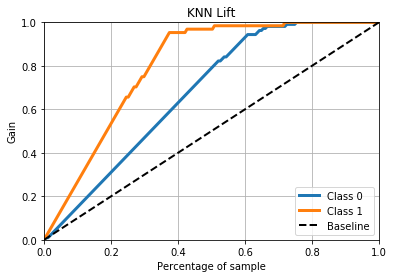

In [28]:
pred_probas_knn = knn.predict_proba(X_test)

# The magic happens here
ax1 =  skplt.metrics.plot_cumulative_gain(y_test, pred_probas_knn)
plt.title('KNN Lift')
plt.show()

Text(0.5, 1.0, 'Decision Tree Lift Curve')

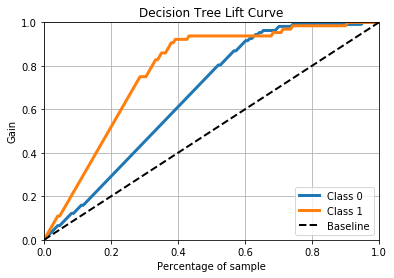

In [29]:
pred_probas_tree = clf_tree.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, pred_probas_tree)
plt.title('Decision Tree Lift Curve')

Text(0.5, 1.0, 'Logistic Regression Lift Curve')

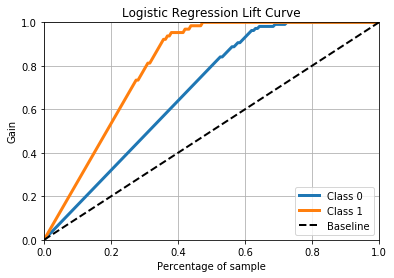

In [30]:
pred_probas_lr = clf_lr.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, pred_probas_lr)
plt.title('Logistic Regression Lift Curve')

Text(0.5, 1.0, 'SVM Lift Curve')

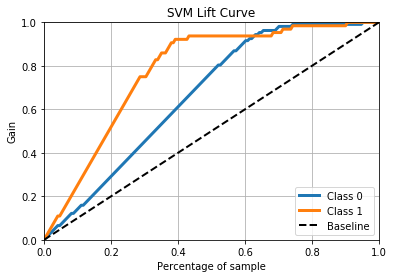

In [31]:
pred_probas_svm = clf_tree.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, pred_probas_svm)
plt.title('SVM Lift Curve')

### Measurement metrics

After fitting three classifiers, namely decision tree, KNN, logistic regression and SVM algrithom, their performances metrix is as following

In [32]:
from sklearn.metrics import precision_recall_fscore_support

matrix = pd.DataFrame(
    [list(precision_recall_fscore_support(y_test, y_predict_tree, average='binary')),
    list(precision_recall_fscore_support(y_test, y_predict_knn, average='binary')),
    list(precision_recall_fscore_support(y_test, y_predict_lr, average='binary')),
    list(precision_recall_fscore_support(y_test, y_predict_svm, average='binary'))],
    columns = ['precision','recall','Fscore','support'],
    index  = ['decision tree','knn','logistic regression','SVM'])
matrix = matrix.iloc[:,:-1]
matrix['accuracy'] =[dtree_scores.mean(),knn_scores.mean(),lr_scores.mean(),
                     svm_scores.mean()]

matrix

,precision,recall,Fscore,accuracy
decision tree,0.867647,0.921875,0.893939,0.935263
knn,0.948276,0.859375,0.901639,0.948929
logistic regression,0.966667,0.906250,0.935484,0.964814
SVM,0.966667,0.906250,0.935484,0.961335


Conclusion:

In this approach, I used K-Fold Cross-Validation to evaluate performance of each model by handling the variance problem of the result set. To identify the best algorithm and best parameters, Grid Search algorithm comes into play on each model.

As we can see, logistic regression has the highest score across precision, recall, accuracy and Fscore. Also, from three confusion matrix, rbf SVM and logistic regression capture most 'ground true malignant' and 'ground true benign' conditions compared to decision tree and knn methods.  

In this case, logistic regression and SVM are suitable for the classification job.

---